In [1]:
import cv2,sys, copy, scipy
import torch
import fiona, rasterio
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision 
import torchvision.models as models
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader,Dataset
from shapely import geometry
from rasterio.mask import mask 
from tqdm import tqdm
from extractor_helper import extractor
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output

## for reprodusability
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## Data preprosseing 

In [2]:
class mydata(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X = torch.tensor(self.data[idx][0]).permute(2,0,1).float()
        y = torch.tensor(self.data[idx][1])
        return X, y

In [59]:
# INTER_NEAREST – a nearest-neighbor interpolation.
# INTER_LINEAR – a bilinear interpolation (used by default)
# INTER_AREA – resampling using pixel area relation. ...
# INTER_CUBIC – a bicubic interpolation over 4×4 pixel neighborhood.
# INTER_LANCZOS4 – a Lanczos interpolation over 8×8 pixel neighborhood.

def processing(patchsize = 3, interporlation = cv2.INTER_LANCZOS4, size = (224,224), threeclass=False):
    
    test2_img = rasterio.open("data/test2/pp_2_sat_modified.tif")
    test2_points = fiona.open("data/test2/points_2_modified_Copy.shp", "r")
    test3_img = rasterio.open("data/test3/pp_3_sat_modified.tif")
    test3_points = fiona.open("data/test3/targets_Copy.shp", "r")
    test4_img = rasterio.open("data/test4/pp_4_sat_modified_spline.tif")
    test4_points = fiona.open("data/test4/modified_points_Copy.shp", "r")
    
    patch2, coordinates2, labels2 = extractor(test2_img,test2_points, size=patchsize, normalize=True, labeling=True)
    patch3, coordinates3, labels3 = extractor(test3_img,test3_points, size=patchsize, normalize=True, labeling=True)
    patch4, coordinates4, labels4 = extractor(test4_img,test4_points, size=patchsize, normalize=True, labeling=True)
    
    patch2 = [(cv2.resize(i,size,interpolation=interporlation), l) for i,l in zip(patch2, labels2)]
    patch3 = [(cv2.resize(i,size,interpolation=interporlation), l) for i,l in zip(patch3, labels3)]
    patch4 = [(cv2.resize(i,size,interpolation=interporlation), l) for i,l in zip(patch4, labels4)]
    data = np.array(patch2 + patch3 + patch4)
    
    ## calculate class weights 
    dom = max(np.unique(labels2 + labels3 + labels4,return_counts=True)[1])
    class_weights = np.array([dom/i for i in np.unique(labels2 + labels3 + labels4,return_counts=True)[1]]) / 12.3333333333
    
    ## you do not want smallest class
    if threeclass:
        data = data[~np.isin(np.arange(len(data)), [j for j, i in enumerate(data) if i[1]==2])] ## Exclude class 2
        for j,i in enumerate(data):
            if i[1] == 3.0:
                data[j][1] = 2
                
    return data, class_weights

In [60]:
def loaders(data, valsize=150, bsize=30):
    
    val_idx = list(np.random.randint(0,len(data), valsize))
    train_idx = list(set(list(range(len(data)))) - set(val_idx))
    trainloader = DataLoader(mydata(data[train_idx]), batch_size=bsize,
                             shuffle=True, num_workers=8, pin_memory=True )
    testloader  = DataLoader(mydata(data[val_idx]), batch_size=bsize,
                             num_workers=8, pin_memory=True )
    
    return (train_idx, val_idx), trainloader, testloader

In [61]:
def train(model, epoches, criterion, optimizer, trainloader, testloader, device, exp_name=None, scheduler=None):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    if exp_name:
        writer = SummaryWriter('./logs_weeklearns/{}'.format(exp_name))
    else:
        writer = SummaryWriter('./logs_weeklearns/{}'.format('single_ep'))
        
    bestval = {'bestvalacc': 0 , 'epoch': None, 'trainacc@Bval': None, 'iter':0}
    for e in (range(1, epoches+1)):
        
        model.train()
        meanloss = {'counter':0, 'correct':0, 'total':0}
        for X, y in (trainloader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            bestval['iter'] +=1
            meanloss['total'] += len(y)
            meanloss['correct'] += (torch.argmax(pred, dim=1) == y).sum().item()
            writer.add_scalar("train_loss", loss.item(), global_step=bestval['iter'])
            
        writer.add_scalar("train_epoch_Accuracy", meanloss['correct']/len(trainloader.dataset), global_step=e)
        print('Epoch:{} |train_accuracy:{}'.format(e, meanloss['correct']/meanloss['total']))
        model.eval()
        meanlossval = {'loss':0, 'counter':0, 'correct':0,'total':0}
        for X, y in testloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            meanlossval['loss'] += criterion(pred, y).item()
            meanlossval['total'] += len(y)
            meanlossval['correct'] += (torch.argmax(pred, dim=1) == y).sum().item()
            
        writer.add_scalar("test_epoch_Accuracy", meanlossval['correct']/len(testloader.dataset), global_step=e)
        print('Epoch:{} |test_accuracy:{}'.format(e, meanlossval['correct']/meanlossval['total']))
        print('--'*50)
        if scheduler:
            scheduler.step()
            
        if meanlossval['correct']/meanlossval['total'] > bestval['bestvalacc']:
            bestval['bestvalacc'] = meanlossval['correct']/meanlossval['total']
            bestval['trainacc@Bval'] = meanloss['correct']/meanloss['total']
            bestval['epoch'] = e
            best_model_wts = copy.deepcopy(model.state_dict())
            
    print(bestval)
    model.load_state_dict(best_model_wts)
    return model

In [62]:
patchsize = 3 ### size of a patch 
interporlation = cv2.INTER_LANCZOS4 ### interpolation for resizing image 

data, class_weights = processing(patchsize=patchsize, 
                                 interporlation = interporlation,
                                 threeclass=True)
batchsize = 30
valsize = int(len(data) * .15) ## validation size 15 percent

split_idx, trainloader, testloader = loaders(data, valsize=valsize, bsize=batchsize)

/home/dsdr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


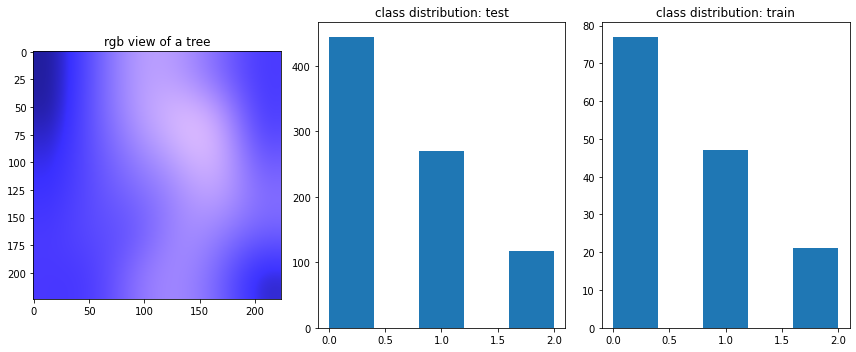

In [63]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(data[3][0][...,[2,3,5]]*10)
plt.title('rgb view of a tree')
plt.subplot(1,3,2)
plt.hist([i[1] for i in data[split_idx[0]]], bins=5);
plt.title('class distribution: test')
plt.subplot(1,3,3)
plt.hist([i[1] for i in data[split_idx[1]]], bins=5);
plt.title('class distribution: train');
plt.tight_layout()

In [68]:
from datetime import datetime
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

####### SELECT MODELS and freeze weights
model = models.resnet18(pretrained=True)
# model = models.resnet34(pretrained=True)
# model = models.resnet50(pretrained=True)
# model = models.wide_resnet50_2(pretrained=True)
model.requires_grad_(False);

###### CHANGE Classifier 
# model.conv1 = nn.Conv2d(8,64, kernel_size=(7,7), stride=(2, 2), padding=(3, 3), bias=False)
# model.fc = nn.Linear(512,3)

model.conv1 = nn.Conv2d(8,64, kernel_size=(7,7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Sequential(
                         nn.Dropout(0.4),
                         nn.Linear(512,256),
                         nn.BatchNorm1d(256),
                         nn.ReLU(),
                         nn.Linear(256,3))
                         
# model.conv1 = nn.Conv2d(8,64, kernel_size=(7,7), stride=(2, 2), padding=(3, 3), bias=False)
# model.fc = nn.Sequential(nn.Dropout(p=0.5),
#                          nn.Linear(2048,1000),
#                          nn.BatchNorm1d(1000),
#                          nn.ReLU(),
#                          nn.Dropout(0.5),
#                          nn.Linear(1000, 4)
#                         )


model.to(device)
epoches = 15
learning_rate = 3e-3
w_decay = 1e-4

parameters  = [{'params': model.conv1.parameters(),'lr': 1e-4},
               {'params': model.fc.parameters()}]

# class_weights = torch.tensor(class_weights, dtype = torch.float32).to(device)
class_weights = None
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam( parameters,
                              lr=learning_rate,
                              weight_decay=w_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [7,10,13], gamma=0.1)
# scheduler = None

params = {'lr':learning_rate,
          'epoches': epoches,
          'weight_dec': w_decay,
          'batch_size': batchsize,
          'interporlation': interporlation,
          'patch_size': patchsize,
          'scheduler': scheduler}

exp_name = datetime.now().isoformat() + str(params)
print(exp_name)

2020-08-10T09:54:48.979317{'lr': 0.003, 'epoches': 15, 'weight_dec': 0.0001, 'batch_size': 30, 'interporlation': 4, 'patch_size': 3, 'scheduler': <torch.optim.lr_scheduler.MultiStepLR object at 0x7fa055fda898>}


In [69]:
best_model = train(model, epoches, criterion, optimizer, trainloader, testloader, device, exp_name, scheduler )

Epoch:1 |train_accuracy:0.7163461538461539
Epoch:1 |test_accuracy:0.2
----------------------------------------------------------------------------------------------------
Epoch:2 |train_accuracy:0.78125
Epoch:2 |test_accuracy:0.6068965517241379
----------------------------------------------------------------------------------------------------
Epoch:3 |train_accuracy:0.7908653846153846
Epoch:3 |test_accuracy:0.696551724137931
----------------------------------------------------------------------------------------------------
Epoch:4 |train_accuracy:0.7896634615384616
Epoch:4 |test_accuracy:0.6482758620689655
----------------------------------------------------------------------------------------------------
Epoch:5 |train_accuracy:0.7475961538461539
Epoch:5 |test_accuracy:0.7448275862068966
----------------------------------------------------------------------------------------------------
Epoch:6 |train_accuracy:0.7728365384615384
Epoch:6 |test_accuracy:0.7724137931034483
------------

In [70]:
with torch.no_grad():
    y_pred,y_true = [],[]
    for b, y in testloader:
        b = b.to(device)
        y_pred.extend(torch.argmax(best_model(b), dim=1).cpu().numpy())
        y_true.extend(y.numpy())

In [71]:
confusion_matrix(y_true, y_pred)

array([[65,  9,  3],
       [ 7, 34,  6],
       [ 1,  0, 20]])

In [26]:
# torch.save(best_model.state_dict(),'./best_ensumble/resnet50_82.pth')

In [72]:
%load_ext tensorboard

import os
logs_base_dir = "./logs_weeklearns/"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

### Fine Tuning 

In [73]:
for param in best_model.parameters():
    param.requires_grad = True

In [74]:
trainable_parameters = best_model.parameters()

learning_rate = 0
optimizer = torch.optim.Adam(
    trainable_parameters, lr=learning_rate, weight_decay=1e-4)

In [75]:
best_model = train(best_model, 1, criterion, optimizer, trainloader, testloader, device)

Epoch:1 |train_accuracy:0.828125
Epoch:1 |test_accuracy:0.8137931034482758
----------------------------------------------------------------------------------------------------
{'bestvalacc': 0.8137931034482758, 'epoch': 1, 'trainacc@Bval': 0.828125, 'iter': 28}


In [76]:
def set_learning_rate(optimizer, new_learning_rate):
    """Set learning rates of the optimizer to `new_learning_rate`."""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_learning_rate

In [77]:
learning_rate = 1e-4
set_learning_rate(optimizer, learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,6 ,gamma=0.1,)

In [78]:
best_model = train(best_model, 20, criterion, optimizer, trainloader, testloader, device, scheduler=scheduler)

Epoch:1 |train_accuracy:0.8221153846153846
Epoch:1 |test_accuracy:0.46206896551724136
----------------------------------------------------------------------------------------------------
Epoch:2 |train_accuracy:0.8629807692307693
Epoch:2 |test_accuracy:0.7517241379310344
----------------------------------------------------------------------------------------------------
Epoch:3 |train_accuracy:0.875
Epoch:3 |test_accuracy:0.6620689655172414
----------------------------------------------------------------------------------------------------
Epoch:4 |train_accuracy:0.9026442307692307
Epoch:4 |test_accuracy:0.6896551724137931
----------------------------------------------------------------------------------------------------
Epoch:5 |train_accuracy:0.9302884615384616
Epoch:5 |test_accuracy:0.7517241379310344
----------------------------------------------------------------------------------------------------
Epoch:6 |train_accuracy:0.9471153846153846
Epoch:6 |test_accuracy:0.77931034482758

In [78]:
# torch.save(best_model.state_dict(),'./best_ensumble/wide_resnet50_80.pth')